In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
/kaggle/input/plant-seedlings-classification/test/6049234e6.png
/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/4ae939d7d.png
/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/b8664f705.png
/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/628b08c82.png
/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/9ab3b61db.png
/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/086894274.png
/kaggle/input/plant-seedlings-classification/train/Common wheat/df584ca28.png
/kaggle/input/plant-seedlings-classification/train/Common wheat/9026da493.png
/kaggle/input/plant-seedlings-classificati

In [2]:
pd.options.display.max_colwidth=999

import glob
len(glob.glob('/kaggle/input/plant-seedlings-classification/train/*/*'))

# 경로 가져오기
train = pd.DataFrame({'path':glob.glob('/kaggle/input/plant-seedlings-classification/train/*/*')})
# 정답 컬럼
train['answer'] = train['path'].apply(lambda x : x.split('/')[-2])
train

,path,answer
0,/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/4ae939d7d.png,Scentless Mayweed
1,/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/b8664f705.png,Scentless Mayweed
2,/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/628b08c82.png,Scentless Mayweed
3,/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/9ab3b61db.png,Scentless Mayweed
4,/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/086894274.png,Scentless Mayweed
...,...,...
4745,/kaggle/input/plant-seedlings-classification/train/Shepherds Purse/f0127f70d.png,Shepherds Purse
4746,/kaggle/input/plant-seedlings-classification/train/Shepherds Purse/179cedc9e.png,Shepherds Purse
4747,/kaggle/input/plant-seedlings-classification/train/Shepherds Purse/a0ec33869.png,Shepherds Purse
4748,/kaggle/input/plant-seedlings-classification/train/Shepherds Purse/33010c8cb.png,Shepherds Purse


In [3]:
# 검증단계 만들기
# 정답 데이터 개수에 맞게 평가셋을 구성해줘야함, stratify=train['answer']
from sklearn.model_selection import train_test_split

x_train , x_valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['answer'])

In [4]:
from keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(horizontal_flip=True) # 데이터증식 : 1)이미지좌우반전

train_generator = idg.flow_from_dataframe(x_train, x_col='path', y_col='answer', target_size=(300,300), batch_size=32)
valid_generator = idg.flow_from_dataframe(x_valid, x_col='path', y_col='answer', target_size=(300,300), batch_size=32)

Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


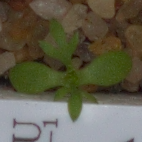

In [5]:
from PIL import Image
Image.open('/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/4ae939d7d.png')

In [6]:
# 모델 선언
from tensorflow.keras.applications.efficientnet import EfficientNetB0 
from keras import *
from keras.layers import *

model = Sequential()

model.add(EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')) # 'pooling'
model.add(Dense(12,activation='softmax'))
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 12)                15372     
Total params: 4,064,943
Trainable params: 4,022,920
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(patience=3, verbose=1) # 점수가 점점 안좋아지면 2번까지 참고 일찍 학습 종료
mc = ModelCheckpoint('best.h5', save_best_only=True, verbose=1) # 최적의 순간을 저장, 학습한 것 중 제일 성능 좋은 것만 저장하자!!
rl = ReduceLROnPlateau(patience=2, verbose=1)

# 모델 선언 마무리(학습)
model.compile(metrics=['acc'], loss='categorical_crossentropy', optimizer='adam')
model.fit(train_generator, validation_data = valid_generator, epochs=100, callbacks=[es,mc,rl]) # epochs 학습횟수 지정, 기본은 1
model.load_weights('best.h5')

Epoch 1/100
119/119 [==============================] - 143s 1s/step - loss: 1.0523 - acc: 0.6467 - val_loss: 0.9831 - val_acc: 0.7063

Epoch 00001: val_loss improved from inf to 0.98311, saving model to best.h5
Epoch 2/100
119/119 [==============================] - 77s 645ms/step - loss: 0.2185 - acc: 0.9233 - val_loss: 0.5390 - val_acc: 0.8232

Epoch 00002: val_loss improved from 0.98311 to 0.53902, saving model to best.h5
Epoch 3/100
119/119 [==============================] - 78s 650ms/step - loss: 0.1214 - acc: 0.9564 - val_loss: 0.5407 - val_acc: 0.8347

Epoch 00003: val_loss did not improve from 0.53902
Epoch 4/100
119/119 [==============================] - 77s 646ms/step - loss: 0.1093 - acc: 0.9632 - val_loss: 0.5295 - val_acc: 0.8663

Epoch 00004: val_loss improved from 0.53902 to 0.52948, saving model to best.h5
Epoch 5/100
119/119 [==============================] - 76s 640ms/step - loss: 0.0944 - acc: 0.9707 - val_loss: 0.2134 - val_acc: 0.9442

Epoch 00005: val_loss improved

In [8]:
# 예측
test = pd.DataFrame({'path':glob.glob("/kaggle/input/plant-seedlings-classification/test/*")})

idg2 = ImageDataGenerator()

# test_generator 만들때 옵션 두가지 더! (class_mode, shuffle=False)
test_generator = idg2.flow_from_dataframe(test, x_col='path', y_col=None, 
                                          target_size=(300,300), batch_size=32, 
                                          class_mode=None, shuffle=False)

Found 794 validated image filenames.


In [9]:
sub = pd.read_csv('/kaggle/input/plant-seedlings-classification/sample_submission.csv')
display(test,sub)

,path
0,/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
1,/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
2,/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
3,/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
4,/kaggle/input/plant-seedlings-classification/test/6049234e6.png
...,...
789,/kaggle/input/plant-seedlings-classification/test/4c7838de4.png
790,/kaggle/input/plant-seedlings-classification/test/fda39e16f.png
791,/kaggle/input/plant-seedlings-classification/test/da4ed3a28.png
792,/kaggle/input/plant-seedlings-classification/test/a83820a2c.png


,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet
...,...,...
789,fea355851.png,Sugar beet
790,fea3da57c.png,Sugar beet
791,fef2ade8c.png,Sugar beet
792,ff65bc002.png,Sugar beet


In [10]:
result = model.predict(test_generator, verbose=1)

25/25 [==============================] - 10s 355ms/step


In [11]:
sub['answer'] = result.argmax(axis=1)
sub

,file,species,answer
0,0021e90e4.png,Sugar beet,6
1,003d61042.png,Sugar beet,11
2,007b3da8b.png,Sugar beet,3
3,0086a6340.png,Sugar beet,2
4,00c47e980.png,Sugar beet,5
...,...,...,...
789,fea355851.png,Sugar beet,3
790,fea3da57c.png,Sugar beet,6
791,fef2ade8c.png,Sugar beet,1
792,ff65bc002.png,Sugar beet,11


In [12]:
seed_class = {0:'Black-grass', 1:'Charlock', 2:'Cleavers', 3:'Common Chickweed', 4:'Common wheat', 5:'Fat Hen', 6:'Loose Silky-bent',
              7:'Maize', 8:'Scentless Mayweed', 9:'Shepherds Purse', 10:'Small-flowered Cranesbill', 11:'Sugar beet'}
sub['species'] = [seed_class[k] for k in sub['answer']]
sub.drop('answer',axis=1,inplace=True)

In [13]:
sub

,file,species
0,0021e90e4.png,Loose Silky-bent
1,003d61042.png,Sugar beet
2,007b3da8b.png,Common Chickweed
3,0086a6340.png,Cleavers
4,00c47e980.png,Fat Hen
...,...,...
789,fea355851.png,Common Chickweed
790,fea3da57c.png,Loose Silky-bent
791,fef2ade8c.png,Charlock
792,ff65bc002.png,Sugar beet


In [14]:
sub['file'] = test['path'].apply(lambda x : x.split('/')[-1])
sub

,file,species
0,fd87b36ae.png,Loose Silky-bent
1,0e8492cb1.png,Sugar beet
2,8d6acbe9b.png,Common Chickweed
3,54b3afd58.png,Cleavers
4,6049234e6.png,Fat Hen
...,...,...
789,4c7838de4.png,Common Chickweed
790,fda39e16f.png,Loose Silky-bent
791,da4ed3a28.png,Charlock
792,a83820a2c.png,Sugar beet


In [15]:
sub.to_csv('sub.csv',index=0)